In [2]:
import pandas as pd
import geopandas as gpd
import numpy as np

from fastdtw import fastdtw

import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter

import matplotlib.pyplot as plt

import rasterio
from osgeo import gdal, ogr, osr
from gdalconst import *
gdal.UseExceptions()

import datetime as dt

import stac

import time

## Obter imagens da área de interesse via STAC (BrazilDataCube)

In [13]:
# Criar conexão com o servidor da STAC
bdc_stac_service = stac.STAC('http://brazildatacube.dpi.inpe.br/')

# Obter itens filtrados pelo objeto JSON (https://stacspec.org/STAC-api.html#operation/postSearchSTAC)
# Filtro: 200 primeiras imagens da coleção 'LC8SR-1' que intersectam o ponto -46.872, -17.150 ("centroide" de paracatu).

items_sentinel = bdc_stac_service.search({'collections':['S2_MSI_L2_SR_LASRC-1'],
                                          "intersects": {"type": "Point",
                                                         "coordinates": [-46.832, -17.220]},
                                          'limit': 1000})

items_landsat = bdc_stac_service.search({'collections':['LC8SR-1'], 
                                         "intersects": {"type": "Point",
                                                        "coordinates": [-46.832, -17.220]},
                                         'limit': 1000})

# Mostrar quantas imagens foram recuperadas
print('Sentinel: ', len(items_sentinel.features))
print('Landsat: ', len(items_landsat.features))

Sentinel:  965
Landsat:  98


date_sentinel = []
for i in items_sentinel.features:
    if '23KKA' in i['id']:
        date_sentinel.append(dt.datetime.strptime(i['properties']['datetime'],'%Y-%m-%dT%H:%M:%S'))
    
fig = plt.subplots(figsize=(15,5))
plt.hist(x = date_sentinel, bins=500);

In [3]:
links_landsat = {}

# Percorrer todos o itens obtidos da STAC
for i in items_landsat.features:
    
    # Adquirir a data da imagem
    date = i['properties']['datetime'][0:10]
    
    # Inserir um item no dicionário 'links' com (chave = data da imagem) e (valor = URL da imagem).
    # IV selecionado: NDVI
    links_landsat[date] = {'ndvi':i['assets']['sr_ndvi']['href'], 'fmask':i['assets']['Fmask4']['href']}

In [4]:
df_landsat = gpd.read_file('./DADOS/pt_ref_23n_final.geojson')
df_landsat.set_index('id', inplace=True)
df_landsat_mask = df_landsat.copy()

    
# Para evitar a execução total dessa célula, salvei o resultado dela (dicionário) em um arquivo. 
# Caso o arquivo seja encontrado, o processamento é evitado
try:
    out_landsat = np.load('./DADOS/out_ref_landsat.npy', allow_pickle=True).item()
    print("Arquivo aberto com sucesso!")
except:
    print("Arquivo não encontrado, amostrando pontos pela série de imagens...")
    
    # Criar um dicionário de saída
    out_landsat = {}
    # Percorrer todas os pares data(k)/URL(v) da lista 'links'
    for k,v in links_landsat.items():
        # Abrir a imagem da URL
        with rasterio.open(v['ndvi']) as src:
            # Obter o valores dos pixel da imagem para as coordenadas dos pontos (amostrar valores)
            val = [x[0] for x in src.sample((zip(df_landsat.geometry.x, df_landsat.geometry.y)))]

            # Inserir o item no dicionário 'out' com (chave = data da imagem) e (valor = lista de valores da imagem).
            out_landsat[k] = val
                    
    print("Amostragem finalizada!")
    
    try:
        np.save('./DADOS/out_ref_landsat.npy', out_landsat)
        print('O resultado foi salvo')
    except:
        print('O resultado não foi salvo')

Arquivo não encontrado, amostrando pontos pela série de imagens...
Amostragem finalizada!
O resultado foi salvo


In [5]:
# Inserir os valores obtidos como colunas no dataframe dos pontos
for k,v in out_landsat.items():
    df_landsat.insert(loc=2,column=dt.datetime.strptime(k,'%Y-%m-%d'), value=v)
    
df_landsat.drop(['operador','geometry','Name','name_2'],1, inplace=True)
# df_landsat.rename(columns={'id': 'date'}, inplace=True)
df_landsat = df_landsat.sort_index().T/10000

In [6]:
try:
    mask_landsat = np.load('./DADOS/out_ref_mask_landsat.npy', allow_pickle=True).item()
    print("Arquivo aberto com sucesso!")
except:
    print("Arquivo não encontrado, amostrando pontos pela série de imagens...")
    
    # Criar um dicionário de saída
    mask_landsat = {}
    # Percorrer todas os pares data(k)/URL(v) da lista 'links'
    for k,v in links_landsat.items():
        # Abrir a imagem da URL
        with rasterio.open(v['fmask']) as src:
            # Obter o valores dos pixel da imagem para as coordenadas dos pontos (amostrar valores)
            val = [x[0] for x in src.sample((zip(df_landsat_mask.geometry.x, df_landsat_mask.geometry.y)))]

            # Inserir o item no dicionário 'out' com (chave = data da imagem) e (valor = lista de valores da imagem).
            mask_landsat[k] = val
                    
    print("Amostragem finalizada!")
    
    try:
        np.save('./DADOS/out_ref_mask_landsat.npy', mask_landsat)
        print('O resultado foi salvo')
    except:
        print('O resultado não foi salvo')

Arquivo não encontrado, amostrando pontos pela série de imagens...
Amostragem finalizada!
O resultado foi salvo


In [7]:
# Inserir os valores obtidos como colunas no dataframe dos pontos
for k,v in mask_landsat.items():
    df_landsat_mask.insert(loc=2,column=dt.datetime.strptime(k,'%Y-%m-%d'), value=v)
    
df_landsat_mask.drop(['operador','geometry','Name','name_2'],1, inplace=True)
df_landsat_mask = df_landsat_mask.sort_index().T

In [8]:
df_filtrado_landsat = pd.DataFrame(((-df_landsat_mask.mask(df_landsat_mask != 0)+1)*df_landsat))
# df_interpolado_landsat = df_filtrado_landsat.interpolate(method='linear', axis=0)

In [9]:
df_filtrado_landsat

id,1,2,3,4,5,6,7,8,9,10,...,41,42,43,44,45,46,47,48,49,50
2016-08-15,0.3031,NaN,NaN,NaN,NaN,NaN,0.7570,0.6181,0.8353,NaN,...,NaN,NaN,NaN,NaN,0.3274,NaN,NaN,NaN,NaN,NaN
2016-08-31,0.3376,0.8074,NaN,0.6366,NaN,NaN,0.7434,0.6924,NaN,0.2854,...,0.2431,NaN,0.5238,0.7747,NaN,0.2969,NaN,0.3275,NaN,0.1919
2016-09-16,NaN,NaN,0.2723,NaN,0.3015,NaN,0.5902,0.6018,NaN,NaN,...,0.2600,NaN,NaN,NaN,NaN,NaN,0.2651,NaN,NaN,NaN
2016-10-02,0.2565,0.3453,0.2580,0.8609,0.2617,0.6517,0.7415,0.7165,0.5940,NaN,...,0.2013,0.2649,0.1948,0.3416,0.2868,0.4692,0.2623,0.4771,NaN,0.1854
2016-10-18,0.4343,0.2672,NaN,0.4158,0.2417,0.5646,0.7165,0.6857,0.2869,0.2731,...,0.3159,0.1967,0.1823,0.4308,0.2390,0.5657,0.2276,0.5640,NaN,0.1766
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-08-26,0.8649,0.7129,0.8588,0.8225,0.5603,0.8227,0.8348,0.7321,0.9088,0.8214,...,0.6302,0.7400,0.8787,0.7028,0.9245,0.7936,0.6583,0.7378,0.8175,0.4906
2020-09-11,0.2685,0.7421,0.3986,0.2767,0.8404,0.7251,0.7554,0.6954,0.8970,0.7872,...,0.8539,0.2129,0.7412,0.4090,0.8060,0.7703,0.7156,0.6167,0.6817,0.6708
2020-09-27,0.2711,0.6030,0.2384,0.2337,0.8853,0.7221,0.7590,0.7373,0.7562,0.7950,...,0.8980,0.2186,0.6692,0.2630,0.2606,0.8039,0.6775,0.4860,0.4609,0.8901
2020-10-13,NaN,NaN,0.2418,NaN,0.4281,NaN,NaN,NaN,0.2795,NaN,...,0.7593,0.2561,0.3365,0.2521,NaN,0.7699,NaN,0.4881,NaN,0.8293


## Criar um dicionário com as datas e links das imagens

In [10]:
links_23kka = {}
links_23kkb = {}
links_23kla = {}
links_23klb = {}

links = {}

# Percorrer todos o itens obtidos da STAC
for i in items_sentinel.features:
    
    # Adquirir a data da imagem
    date = i['properties']['datetime'][0:10]
    
    if '23KKA' == i['properties']['bdc:tile']:
        links_23kka[date] = {'ndvi':i['assets']['NDVI']['href'], 'fmask':i['assets']['Fmask4']['href']}
        
    elif '23KKB' == i['properties']['bdc:tile']:
        links_23kkb[date] = {'ndvi':i['assets']['NDVI']['href'], 'fmask':i['assets']['Fmask4']['href']}
        
    elif '23KLA' == i['properties']['bdc:tile']:
        links_23kla[date] = {'ndvi':i['assets']['NDVI']['href'], 'fmask':i['assets']['Fmask4']['href']}
        
    elif '23KLB' == i['properties']['bdc:tile']:
        links_23klb[date] = {'ndvi':i['assets']['NDVI']['href'], 'fmask':i['assets']['Fmask4']['href']}
        
links['23KKA'] = links_23kka
links['23KKB'] = links_23kkb
links['23KLA'] = links_23kla
links['23KLB'] = links_23klb

## Abrir arquivo de pontos e extrair coordenadas

In [11]:
# Abrir arquivo de pontos
df = gpd.read_file('./DADOS/pt_ref_23s_final.geojson')

df.set_index('id', inplace=True)

In [12]:
df_23kka = df.loc[df.name_2=='23KKA']
df_23kkb = df.loc[df.name_2=='23KKB']
df_23kla = df.loc[df.name_2=='23KLA']
df_23klb = df.loc[df.name_2=='23KLB']

df_23kka_mask = df_23kka.copy()
df_23kkb_mask = df_23kkb.copy()
df_23kla_mask = df_23kla.copy()
df_23klb_mask = df_23klb.copy()

In [13]:
df_23kka

,Name,operador,name_2,geometry
id,,,,
3,Sem nome,Aline,23KKA,POINT Z (255328.505 8070017.180 0.000)
4,Sem nome,Aline,23KKA,POINT Z (303377.259 8054312.352 0.000)
15,Sem nome,Aline,23KKA,POINT Z (290004.315 8062822.618 0.000)
18,Sem nome,Felipe,23KKA,POINT Z (292989.738 8087797.656 0.000)
20,Sem nome,Felipe,23KKA,POINT Z (281606.672 8087048.301 0.000)
27,Sem nome,Felipe,23KKA,POINT Z (270059.461 8094991.469 0.000)
28,Sem nome,Felipe,23KKA,POINT Z (309097.312 8074589.374 0.000)
31,Sem nome,Aline,23KKA,POINT Z (289014.483 8062211.047 0.000)
32,Sem nome,Aline,23KKA,POINT Z (288599.433 8067053.294 0.000)


In [14]:
df_23kkb

,Name,operador,name_2,geometry
id,,,,
1,Sem nome,Aline,23KKB,POINT Z (300124.112 8105903.712 0.000)
2,Sem nome,Aline,23KKB,POINT Z (269082.062 8101674.437 0.000)
7,Café,Aline,23KKB,POINT Z (279950.819 8145041.653 0.000)
8,Café,Aline,23KKB,POINT Z (278567.467 8145128.117 0.000)
16,Sem nome,Aline,23KKB,POINT Z (284047.038 8117959.081 0.000)
17,Sem nome,Felipe,23KKB,POINT Z (283619.227 8157095.195 0.000)
23,Sem nome,Felipe,23KKB,POINT Z (305882.221 8114870.799 0.000)
25,Sem nome,Felipe,23KKB,POINT Z (272428.852 8109141.203 0.000)
38,Sem nome,Aline,23KKB,POINT Z (306529.581 8113880.124 0.000)


In [15]:
df_23kla

,Name,operador,name_2,geometry
id,,,,
9,Sem nome,Aline,23KLA,POINT Z (331231.382 8084757.203 0.000)
13,Sem nome,Aline,23KLA,POINT Z (310615.749 8091309.767 0.000)
14,Sem nome,Aline,23KLA,POINT Z (315076.039 8082127.535 0.000)
19,Sem nome,Felipe,23KLA,POINT Z (337822.605 8076828.520 0.000)
24,Sem nome,Felipe,23KLA,POINT Z (326453.812 8062754.910 0.000)
34,Sem nome,Aline,23KLA,POINT Z (331589.360 8066758.147 0.000)
35,Sem nome,Aline,23KLA,POINT Z (335998.110 8078130.509 0.000)
36,Sem nome,Aline,23KLA,POINT Z (333756.841 8086837.330 0.000)
45,Sem nome,Aline,23KLA,POINT Z (330376.492 8080348.719 0.000)


In [16]:
df_23klb

,Name,operador,name_2,geometry
id,,,,
5,Sem nome,Aline,23KLB,POINT Z (343930.868 8122262.786 0.000)
6,Sem nome,Aline,23KLB,POINT Z (325881.862 8136129.853 0.000)
10,Sem nome,Aline,23KLB,POINT Z (321740.876 8108122.094 0.000)
11,Sem nome,Aline,23KLB,POINT Z (354087.465 8110230.220 0.000)
12,Sem nome,Aline,23KLB,POINT Z (352335.245 8120730.083 0.000)
21,Sem nome,Felipe,23KLB,POINT Z (328509.187 8109728.793 0.000)
22,Sem nome,Felipe,23KLB,POINT Z (364963.547 8122182.367 0.000)
26,Sem nome,Felipe,23KLB,POINT Z (331363.875 8131039.035 0.000)
29,Sem nome,Felipe,23KLB,POINT Z (334172.174 8125561.604 0.000)


## Amostrar os valores das imagens para os pontos de referência

### NDVI

In [17]:
for grid, data in links.items():
    
    for k,v in data.items():    
    
        with rasterio.open(v['ndvi']) as src:

            if '23KKA' == grid:
                val = [x[0] for x in src.sample((zip(df_23kka.geometry.x, df_23kka.geometry.y)))]
                df_23kka.insert(loc=2,column=dt.datetime.strptime(k,'%Y-%m-%d'), value=val)

            elif '23KKB' == grid:
                val = [x[0] for x in src.sample((zip(df_23kkb.geometry.x, df_23kkb.geometry.y)))]
                df_23kkb.insert(loc=2,column=dt.datetime.strptime(k,'%Y-%m-%d'), value=val)

            elif '23KLA' == grid:
                val = [x[0] for x in src.sample((zip(df_23kla.geometry.x, df_23kla.geometry.y)))]
                df_23kla.insert(loc=2,column=dt.datetime.strptime(k,'%Y-%m-%d'), value=val)

            elif '23KLB' == grid:
                val = [x[0] for x in src.sample((zip(df_23klb.geometry.x, df_23klb.geometry.y)))]
                df_23klb.insert(loc=2,column=dt.datetime.strptime(k,'%Y-%m-%d'), value=val)

### Cloud mask

In [18]:
for grid, data in links.items():
    
    for k,v in data.items():    
    
        with rasterio.open(v['fmask']) as src:

            if '23KKA' == grid:
                val = [x[0] for x in src.sample((zip(df_23kka.geometry.x, df_23kka.geometry.y)))]
                df_23kka_mask.insert(loc=2,column=dt.datetime.strptime(k,'%Y-%m-%d'), value=val)

            elif '23KKB' == grid:
                val = [x[0] for x in src.sample((zip(df_23kkb.geometry.x, df_23kkb.geometry.y)))]
                df_23kkb_mask.insert(loc=2,column=dt.datetime.strptime(k,'%Y-%m-%d'), value=val)

            elif '23KLA' == grid:
                val = [x[0] for x in src.sample((zip(df_23kla.geometry.x, df_23kla.geometry.y)))]
                df_23kla_mask.insert(loc=2,column=dt.datetime.strptime(k,'%Y-%m-%d'), value=val)

            elif '23KLB' == grid:
                val = [x[0] for x in src.sample((zip(df_23klb.geometry.x, df_23klb.geometry.y)))]
                df_23klb_mask.insert(loc=2,column=dt.datetime.strptime(k,'%Y-%m-%d'), value=val)

In [19]:
df_23kka.drop(['geometry','operador','Name', 'name_2'],1, inplace=True)
df_23kkb.drop(['geometry','operador','Name', 'name_2'],1, inplace=True)
df_23kla.drop(['geometry','operador','Name', 'name_2'],1, inplace=True)
df_23klb.drop(['geometry','operador','Name', 'name_2'],1, inplace=True)

df_23kka = df_23kka.T/10000
df_23kkb = df_23kkb.T/10000
df_23kla = df_23kla.T/10000
df_23klb = df_23klb.T/10000

df_23kka_mask.drop(['geometry','operador','Name', 'name_2'],1, inplace=True)
df_23kkb_mask.drop(['geometry','operador','Name', 'name_2'],1, inplace=True)
df_23kla_mask.drop(['geometry','operador','Name', 'name_2'],1, inplace=True)
df_23klb_mask.drop(['geometry','operador','Name', 'name_2'],1, inplace=True)

df_23kka_mask = df_23kka_mask.T
df_23kkb_mask = df_23kkb_mask.T
df_23kla_mask = df_23kla_mask.T
df_23klb_mask = df_23klb_mask.T

C:\Users\Felipe.FelipeSa\Anaconda3\envs\neogeo\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [20]:
df_23kka_filtrado = pd.DataFrame(((-df_23kka_mask.mask(df_23kka_mask != 0)+1)*df_23kka))
df_23kkb_filtrado = pd.DataFrame(((-df_23kkb_mask.mask(df_23kkb_mask != 0)+1)*df_23kkb))
df_23kla_filtrado = pd.DataFrame(((-df_23kla_mask.mask(df_23kla_mask != 0)+1)*df_23kla))
df_23klb_filtrado = pd.DataFrame(((-df_23klb_mask.mask(df_23klb_mask != 0)+1)*df_23klb))

df_23kka_interpolado = df_23kka_filtrado.interpolate(method='linear', axis=0)
df_23kkb_interpolado = df_23kkb_filtrado.interpolate(method='linear', axis=0)
df_23kla_interpolado = df_23kla_filtrado.interpolate(method='linear', axis=0)
df_23klb_interpolado = df_23klb_filtrado.interpolate(method='linear', axis=0)

In [ ]:
df_interpolado_sentinel = pd.concat([df_23kka_interpolado, df_23kkb_interpolado, df_23kla_interpolado, df_23klb_interpolado], axis=1, sort=False).T.sort_index().T.sort_index()

In [22]:
df_filtrado_sentinel = pd.concat([df_23kka_filtrado, df_23kkb_filtrado, df_23kla_filtrado, df_23klb_filtrado], axis=1, sort=False).T.sort_index().T.sort_index()

In [23]:
df_filtrado_sentinel

id,1,2,3,4,5,6,7,8,9,10,...,41,42,43,44,45,46,47,48,49,50
2017-01-05,0.8328,NaN,NaN,0.9008,0.9311,0.7048,0.7156,NaN,0.8747,0.8466,...,0.8765,NaN,0.8543,0.6119,0.8580,0.7603,NaN,0.7971,NaN,0.8810
2017-01-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-15,NaN,NaN,0.8169,NaN,0.9039,0.6614,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.7838,NaN
2017-01-25,NaN,0.8574,0.8926,0.9088,0.9021,NaN,NaN,0.7118,0.9269,0.7968,...,0.7676,0.5843,NaN,0.3243,0.8938,NaN,0.8573,NaN,0.9020,NaN
2017-01-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-12-26,NaN,0.8043,NaN,0.8402,NaN,NaN,NaN,NaN,NaN,NaN,...,0.8831,0.6700,NaN,NaN,NaN,NaN,NaN,NaN,0.5672,NaN
2019-12-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-12-31,0.2415,0.7442,NaN,NaN,0.8905,NaN,0.7947,0.8608,NaN,0.4389,...,0.8320,0.7658,0.8496,NaN,0.7037,NaN,NaN,0.5603,0.6552,0.9175


In [24]:
df_filtrado_landsat

id,1,2,3,4,5,6,7,8,9,10,...,41,42,43,44,45,46,47,48,49,50
2016-08-15,0.3031,NaN,NaN,NaN,NaN,NaN,0.7570,0.6181,0.8353,NaN,...,NaN,NaN,NaN,NaN,0.3274,NaN,NaN,NaN,NaN,NaN
2016-08-31,0.3376,0.8074,NaN,0.6366,NaN,NaN,0.7434,0.6924,NaN,0.2854,...,0.2431,NaN,0.5238,0.7747,NaN,0.2969,NaN,0.3275,NaN,0.1919
2016-09-16,NaN,NaN,0.2723,NaN,0.3015,NaN,0.5902,0.6018,NaN,NaN,...,0.2600,NaN,NaN,NaN,NaN,NaN,0.2651,NaN,NaN,NaN
2016-10-02,0.2565,0.3453,0.2580,0.8609,0.2617,0.6517,0.7415,0.7165,0.5940,NaN,...,0.2013,0.2649,0.1948,0.3416,0.2868,0.4692,0.2623,0.4771,NaN,0.1854
2016-10-18,0.4343,0.2672,NaN,0.4158,0.2417,0.5646,0.7165,0.6857,0.2869,0.2731,...,0.3159,0.1967,0.1823,0.4308,0.2390,0.5657,0.2276,0.5640,NaN,0.1766
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-08-26,0.8649,0.7129,0.8588,0.8225,0.5603,0.8227,0.8348,0.7321,0.9088,0.8214,...,0.6302,0.7400,0.8787,0.7028,0.9245,0.7936,0.6583,0.7378,0.8175,0.4906
2020-09-11,0.2685,0.7421,0.3986,0.2767,0.8404,0.7251,0.7554,0.6954,0.8970,0.7872,...,0.8539,0.2129,0.7412,0.4090,0.8060,0.7703,0.7156,0.6167,0.6817,0.6708
2020-09-27,0.2711,0.6030,0.2384,0.2337,0.8853,0.7221,0.7590,0.7373,0.7562,0.7950,...,0.8980,0.2186,0.6692,0.2630,0.2606,0.8039,0.6775,0.4860,0.4609,0.8901
2020-10-13,NaN,NaN,0.2418,NaN,0.4281,NaN,NaN,NaN,0.2795,NaN,...,0.7593,0.2561,0.3365,0.2521,NaN,0.7699,NaN,0.4881,NaN,0.8293


In [29]:
pd.concat([df_filtrado_landsat,df_filtrado_sentinel]).sort_index().to_pickle('./DADOS/df_ref_both.pkl')

In [6]:
df = pd.read_pickle('./DADOS/df_ref_both.pkl')
df_interpolado = df.interpolate(method='linear', axis=0).resample('2W').first().interpolate(method='linear', axis=0)
df_interpolado

id,1,2,3,4,5,6,7,8,9,10,...,41,42,43,44,45,46,47,48,49,50
2016-08-21,0.30310,NaN,NaN,NaN,NaN,NaN,0.7570,0.6181,0.835300,NaN,...,NaN,NaN,NaN,NaN,0.327400,NaN,NaN,NaN,NaN,NaN
2016-09-04,0.33760,0.80740,NaN,0.63660,NaN,NaN,0.7434,0.6924,0.754867,0.28540,...,0.24310,NaN,0.52380,0.77470,0.313867,0.29690,NaN,0.32750,NaN,0.19190
2016-09-18,0.29705,0.57635,0.27230,0.74875,0.3015,NaN,0.5902,0.6018,0.674433,0.28130,...,0.26000,NaN,0.35930,0.55815,0.300333,0.38305,0.26510,0.40230,NaN,0.18865
2016-10-02,0.25650,0.34530,0.25800,0.86090,0.2617,0.65170,0.7415,0.7165,0.594000,0.27720,...,0.20130,0.26490,0.19480,0.34160,0.286800,0.46920,0.26230,0.47710,NaN,0.18540
2016-10-16,0.34540,0.30625,0.28905,0.63835,0.2517,0.60815,0.7290,0.7011,0.440450,0.27515,...,0.25860,0.23080,0.18855,0.38620,0.262900,0.51745,0.24495,0.52055,NaN,0.18100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-09-13,0.26850,0.74210,0.39860,0.27670,0.8404,0.72510,0.7554,0.6954,0.897000,0.78720,...,0.85390,0.21290,0.74120,0.40900,0.806000,0.77030,0.71560,0.61670,0.6817,0.67080
2020-09-27,0.27110,0.60300,0.23840,0.23370,0.8853,0.72210,0.7590,0.7373,0.756200,0.79500,...,0.89800,0.21860,0.66920,0.26300,0.260600,0.80390,0.67750,0.48600,0.4609,0.89010
2020-10-11,0.27110,0.60300,0.24010,0.23370,0.6567,0.72210,0.7590,0.7373,0.517850,0.79500,...,0.82865,0.23735,0.50285,0.25755,0.260600,0.78690,0.67750,0.48705,0.4609,0.85970
2020-10-25,0.27110,0.60300,0.24180,0.23370,0.4281,0.72210,0.7590,0.7373,0.279500,0.79500,...,0.75930,0.25610,0.33650,0.25210,0.260600,0.76990,0.67750,0.48810,0.4609,0.82930


## Definição dos anos agrícolas

In [7]:
anos_ag = {'2016':[dt.datetime(2016, 9, 1), dt.datetime(2017, 8, 31)],
           '2017':[dt.datetime(2017, 9, 1), dt.datetime(2018, 8, 31)],
           '2018':[dt.datetime(2018, 9, 1), dt.datetime(2019, 8, 31)],
           '2019':[dt.datetime(2019, 9, 1), dt.datetime(2020, 8, 31)]}

## Plot

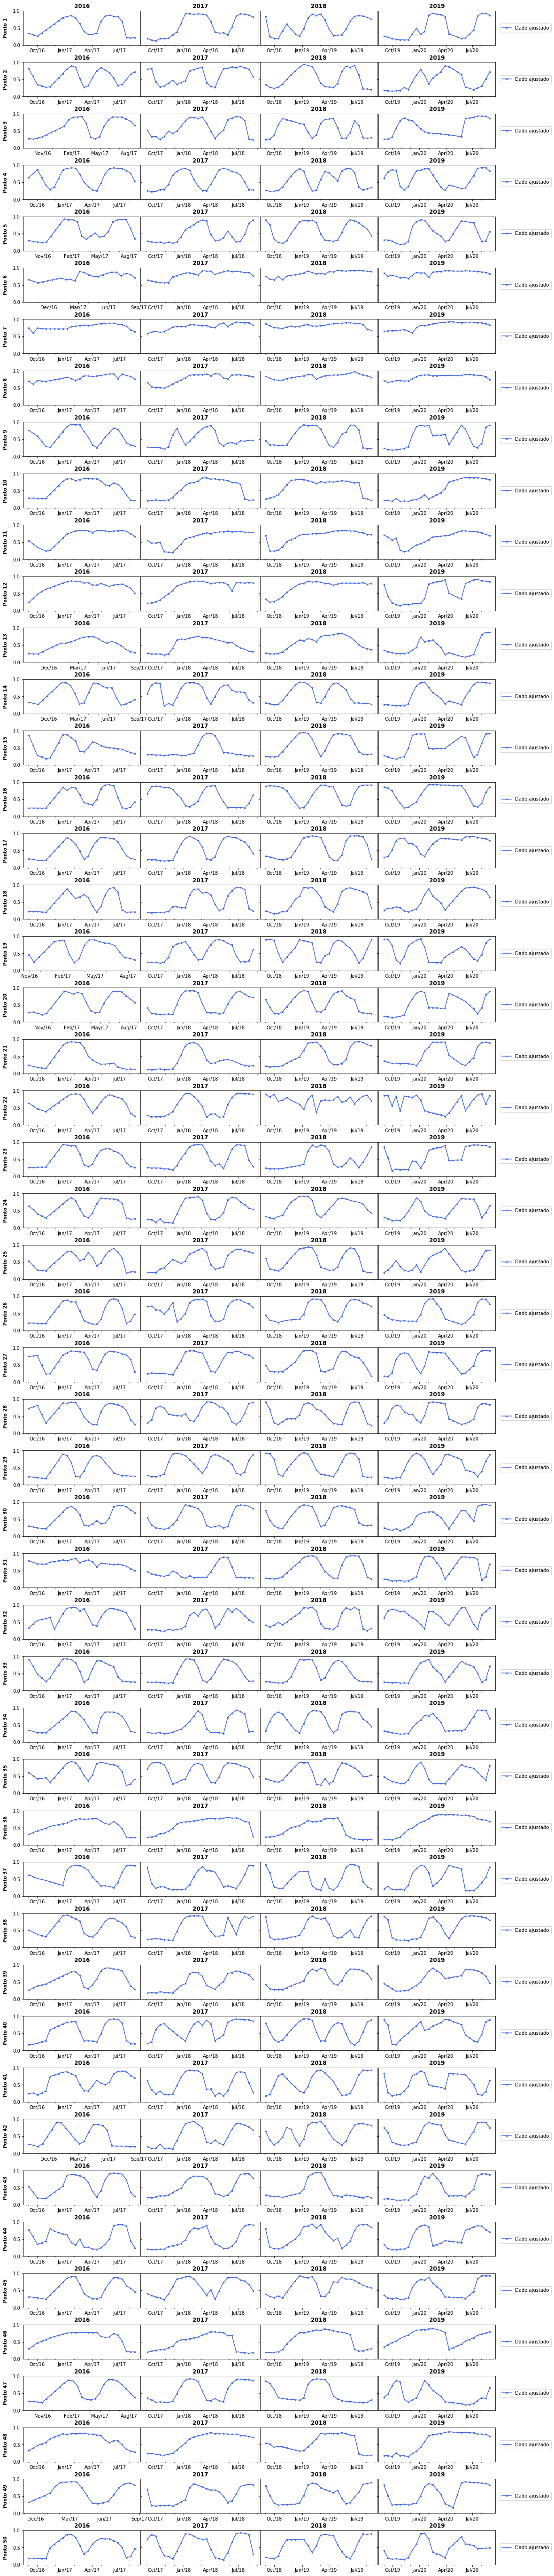

In [48]:
fig, ax = plt.subplots(df_interpolado.shape[1],len(anos_ag),figsize=(18,100),sharey=True)
fig.subplots_adjust(wspace = .015,hspace=.5)

for linha in range(df_interpolado.shape[1]):
    ponto = linha + 1
    for (coluna,ano), intervalo in zip(enumerate(anos_ag),anos_ag.values()):
        
        ax[linha,coluna].set_ylim(0,1)

        months = mdates.MonthLocator(interval=3)
        month_fmt = mdates.DateFormatter('%b/%y')
        
        months_minor = mdates.MonthLocator()
        
        ax[linha,coluna].get_xaxis().set_minor_locator(months_minor)
        ax[linha,coluna].get_xaxis().set_major_locator(months)
        ax[linha,coluna].get_xaxis().set_major_formatter(month_fmt)

        ax[linha,coluna].set_title(ano,weight='bold')

        ax[linha,coluna].plot(df_interpolado.loc[intervalo[0]:intervalo[1],ponto],marker='.',ms=5, label='Dado ajustado', color='royalblue');
#         ax[linha,coluna].plot(df.loc[intervalo[0]:intervalo[1],ponto],lw=.5, color='red', ls='-.', label='Dado bruto');
#         ax[linha,coluna].plot(df_filtrado.loc[intervalo[0]:intervalo[1],ponto],marker='.',lw=0, mec='black', mfc='black', ms=7, label='Valores válidos');

    ax[linha,0].set_ylabel('Ponto {}'.format(ponto),labelpad=10,weight='bold')
    ax[linha,3].legend(bbox_to_anchor=(1.5, .5), loc='center right');


In [10]:
selecao = {'2016':[x for x in range(1,51) if x != 31],
           '2017':[x for x in range(1,51)], 
           '2018':[x for x in range(1,51) if x != 22],
           '2019':[x for x in range(1,51) if x != 22]}

corte = dt.timedelta(days=45)

amostras = pd.DataFrame(np.zeros((20,1)))


for k, v in selecao.items():
    df_secundario = (df_interpolado.loc[anos_ag[k][0] + corte : anos_ag[k][1] - corte, v]).reset_index(drop=True)
    amostras = amostras.join(df_secundario,lsuffix='_')
    
amostras.columns = np.arange(len(amostras.columns))
amostras.drop([0],1,inplace=True)
amostras = amostras.loc[:18,:]
amostras.to_pickle('./DADOS/df_ref_final.pkl')

amostras

,1,2,3,4,5,6,7,8,9,10,...,188,189,190,191,192,193,194,195,196,197
0,0.345400,0.306250,0.289050,0.638350,0.251700,0.608150,0.729000,0.701100,0.440450,0.275150,...,0.222200,0.243660,0.130060,0.201400,0.236220,0.601571,0.831440,0.174200,0.247800,0.158480
1,0.434300,0.267200,0.320100,0.415800,0.241700,0.564600,0.716500,0.685700,0.286900,0.273100,...,0.311900,0.233050,0.142100,0.209733,0.244550,0.651650,0.324760,0.180300,0.267600,0.148050
2,0.525250,0.282400,0.382200,0.277300,0.257000,0.592640,0.716320,0.710183,0.263000,0.397825,...,0.451400,0.248800,0.136100,0.256000,0.282500,0.696700,0.236100,0.147400,0.242000,0.209300
3,0.616200,0.410560,0.444300,0.358400,0.425525,0.620680,0.716140,0.734667,0.415925,0.522550,...,0.770320,0.297170,0.239208,0.573860,0.585818,0.776233,0.306700,0.244985,0.272347,0.418450
4,0.707150,0.538720,0.506400,0.608150,0.594050,0.648720,0.715960,0.759150,0.568850,0.647275,...,0.819775,0.333050,0.304515,0.789350,0.746700,0.839725,0.367214,0.310569,0.298359,0.597721
5,0.798100,0.666880,0.568500,0.857900,0.762575,0.676760,0.715780,0.783633,0.721775,0.772000,...,0.898250,0.594700,0.608560,0.880657,0.822900,0.849367,0.604400,0.425157,0.504325,0.901300
6,0.832800,0.795040,0.630600,0.900800,0.931100,0.704800,0.715600,0.808117,0.874700,0.846600,...,0.852850,0.811167,0.827400,0.908943,0.795950,0.854978,0.872867,0.583450,0.773650,0.910450
7,0.858667,0.890300,0.816900,0.916175,0.903900,0.661400,0.788818,0.772200,0.936200,0.842733,...,0.500400,0.901900,0.783000,0.856500,0.883800,0.871650,0.740525,0.762600,0.862050,0.758000
8,0.789644,0.857400,0.892600,0.908800,0.902100,0.664917,0.798236,0.711800,0.926900,0.796800,...,0.461733,0.861500,0.914100,0.297600,0.709100,0.887200,0.577750,0.794267,0.832000,0.360700
9,0.620878,0.526080,0.901257,0.731886,0.837420,0.613367,0.812364,0.769640,0.920180,0.822043,...,0.442400,0.841300,0.777225,0.336000,0.608400,0.858500,0.496362,0.810100,0.693225,0.318675


In [63]:
classif = pd.DataFrame(np.load('./DADOS/classif.npy', allow_pickle=True), columns=['2016', '2017', '2018', '2019'])
classif

,2016,2017,2018,2019
0,False,False,False,True
1,False,False,False,True
2,False,False,True,True
3,False,False,False,True
4,True,True,True,True
...,...,...,...,...
10925,False,False,False,False
10926,False,True,True,True
10927,True,True,True,False
10928,True,True,False,False


In [ ]:
fig, ax = plt.subplots(df_interpolado.shape[1]-10900,len(anos_ag),figsize=(18,100),sharey=True)
fig.subplots_adjust(wspace = .015,hspace=.5)

for linha in range(df_interpolado.shape[1]-10900):
    ponto = linha + 1
    for (coluna,ano), intervalo in zip(enumerate(anos_ag),anos_ag.values()):
        
        if not classif.loc[ponto, ano]:
            cor = 'red'
        else:
            cor = 'royalblue'
        
        ax[linha,coluna].set_ylim(0,1)

        months = mdates.MonthLocator(interval=3)
        month_fmt = mdates.DateFormatter('%b/%y')
        
        months_minor = mdates.MonthLocator()
        
        ax[linha,coluna].get_xaxis().set_minor_locator(months_minor)
        ax[linha,coluna].get_xaxis().set_major_locator(months)
        ax[linha,coluna].get_xaxis().set_major_formatter(month_fmt)

        ax[linha,coluna].set_title(ano,weight='bold')

        ax[linha,coluna].plot(df_interpolado.loc[intervalo[0]:intervalo[1],ponto],marker='.',ms=5, label='Dado ajustado', color=cor);
#         ax[linha,coluna].plot(df.loc[intervalo[0]:intervalo[1],ponto],lw=.5, color='red', ls='-.', label='Dado bruto');
#         ax[linha,coluna].plot(df_filtrado.loc[intervalo[0]:intervalo[1],ponto],marker='.',lw=0, mec='black', mfc='black', ms=7, label='Valores válidos');

    ax[linha,0].set_ylabel('Ponto {}'.format(ponto),labelpad=10,weight='bold')
#     ax[linha,3].legend(bbox_to_anchor=(1.5, .5), loc='center right');